In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import joblib

In [ ]:
# Fixed seeds for reproducibility
torch.manual_seed(1)
np.random.seed(1) 

In [26]:
# Defining transformations
mnist_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalizing between -1 and 1
])

# Loading datasets
train_dataset = datasets.FashionMNIST(root="./datasets/", train=True, download=True, transform=mnist_transforms)
test_dataset = datasets.FashionMNIST(root="./datasets/", train=False, download=True, transform=mnist_transforms)

# Combining train and validation datasets
full_train_dataset = train_dataset

# Creating data loaders
train_loader = DataLoader(dataset=full_train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

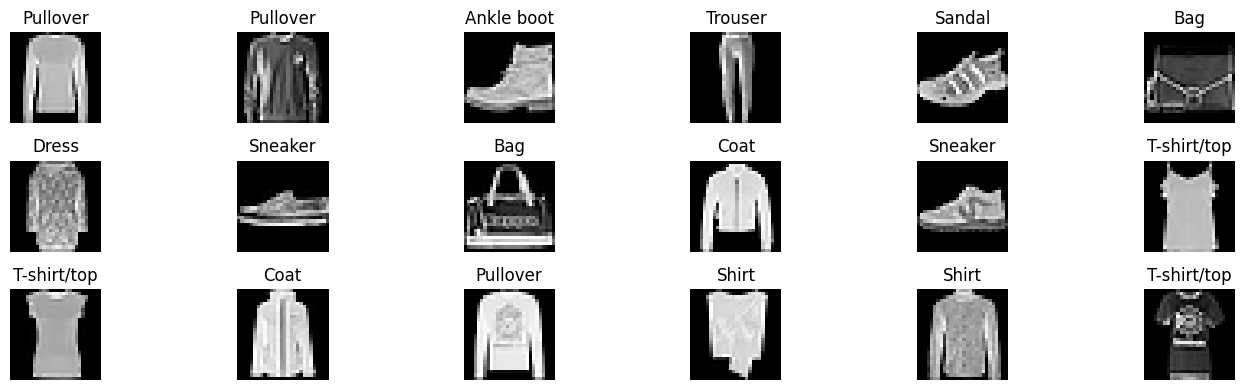

In [27]:
torch.manual_seed(1)

fig = plt.figure(figsize=(16, 4))
rows, cols = 3, 6
class_names = train_dataset.classes

# Visualizing sample images from dataset
for i in range(1, (rows * cols) + 1):
    rand_ind = torch.randint(0, len(train_dataset), size=[1]).item()
    img, label = train_dataset[rand_ind]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"{class_names[label]}")
    plt.axis('off')
    plt.tight_layout()
plt.show()

In [28]:
# We define VAE model per architecture of M1 model from Kingma et al.
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=500, latent_dim=50):
        super(VAE, self).__init__()
        # Encoder layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)     # Mean vector
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim) # Log-variance vector

        # Decoder layers
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        mu = self.fc_mu(h1)
        logvar = self.fc_logvar(h1)
        return mu, logvar  # Returning params of latent Gaussian distribution

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)      # Standard deviation
        eps = torch.randn_like(std)        # Sample epsilon from standard normal
        return mu + eps * std              # Reparameterization trick

    def decode(self, z):
        h3 = F.relu(self.fc3(z))  # Hidden layer activation
        return torch.sigmoid(self.fc4(h3))  # Output activation to constrain [0, 1]

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))  # Flattening the input
        z = self.reparameterize(mu, logvar)        # Sample from the latent space
        x_recon = self.decode(z)                   # Reconstructing the input
        return x_recon, mu, logvar

In [29]:
# Loss function for VAE is combo of reconstruction loss and KL divergence
# def loss_function(recon_x, x, mu, logvar):
#     # Reconstruction loss (Binary Cross Entropy)
#     BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
#     # KL divergence between latent distribution and standard normal distribution
#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     return BCE + KLD

def loss_function(recon_x, x, mu, logvar, return_parts=False):
    # Binary Cross-Entropy Loss
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # KL Divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    if return_parts:
        return BCE, KLD  # Return both parts for debugging
    return BCE + KLD  # Default behavior

# Initializing VAE and optimizer
vae = VAE(input_dim=784, hidden_dim=500, latent_dim=50)
optimizer = optim.Adam(vae.parameters(), lr=1e-4)

In [31]:
# Training our VAE using training data
num_epochs = 30
vae.train()

for epoch in range(1, num_epochs + 1):
    train_loss = 0  # Adding total loss across batches
    num_batches = len(train_loader)  # Total number of batches

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, 784)  # Flattening input images

        # Checking and adjusting input range if necessary ([-1, 1] to [0, 1])
        if data.min().item() < 0:
            data = (data + 1) / 2  # Normalizing to [0, 1]
            #print(f"Input adjusted to range [0, 1]")

        optimizer.zero_grad()  # Reset gradients

        # Forward pass through VAE
        recon_batch, mu, logvar = vae(data)

        # I retrieve BCE and KLD instead of their sum directly for debugging
        bce, kld = loss_function(recon_batch, data, mu, logvar, return_parts=True)
        #print(f"BCE: {bce.item()}, KLD: {kld.item()}")

        # Calculating total loss (BCE + KLD)
        loss = bce + kld

        # Backpropagation with gradient clipping to avoid exploding gradients
        loss.backward()
        torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)

        train_loss += loss.item()  # Adding loss across batches
        optimizer.step()  # Updating our model parameters

    # Dividing by the number of batches
    avg_loss = train_loss / num_batches
    print(f'Epoch: {epoch} \t Average loss: {avg_loss:.4f}')


Epoch: 1 	 Average loss: 41352.1391
Epoch: 2 	 Average loss: 36663.7337
Epoch: 3 	 Average loss: 35632.7819
Epoch: 4 	 Average loss: 35094.3233
Epoch: 5 	 Average loss: 34702.7054
Epoch: 6 	 Average loss: 34383.5075
Epoch: 7 	 Average loss: 34113.1945
Epoch: 8 	 Average loss: 33883.4595
Epoch: 9 	 Average loss: 33654.5986
Epoch: 10 	 Average loss: 33439.4572
Epoch: 11 	 Average loss: 33226.2929
Epoch: 12 	 Average loss: 33024.7424
Epoch: 13 	 Average loss: 32835.3576
Epoch: 14 	 Average loss: 32679.1000
Epoch: 15 	 Average loss: 32526.8308
Epoch: 16 	 Average loss: 32400.0494
Epoch: 17 	 Average loss: 32292.4486
Epoch: 18 	 Average loss: 32199.5013
Epoch: 19 	 Average loss: 32113.3813
Epoch: 20 	 Average loss: 32039.5487
Epoch: 21 	 Average loss: 31968.9215
Epoch: 22 	 Average loss: 31908.7304
Epoch: 23 	 Average loss: 31852.2296
Epoch: 24 	 Average loss: 31794.8630
Epoch: 25 	 Average loss: 31747.0071
Epoch: 26 	 Average loss: 31698.3071
Epoch: 27 	 Average loss: 31657.0184
Epoch: 28 

In [32]:
# Extrating latent representations (mean of the encoder output) for both training and test datasets
vae.eval()

# Function to get latent representations
def get_latent_representations(dataloader):
    latent_reps = []
    labels_list = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.view(-1, 784)
            mu, _ = vae.encode(data)
            latent_reps.append(mu)
            labels_list.append(labels)
    latent_reps = torch.cat(latent_reps)
    labels_list = torch.cat(labels_list)
    return latent_reps.numpy(), labels_list.numpy()

# Getting latent representations
train_latent, train_labels = get_latent_representations(train_loader)
test_latent, test_labels = get_latent_representations(test_loader)

In [38]:
# Training SVM classifier using latent representations of training data with labeled samples
label_sizes = [100, 600, 1000, 3000]
results = {}

for num_labels in label_sizes:
    # Randomly selecting num_labels samples from the training data
    indices = np.random.choice(len(train_latent), size=num_labels, replace=False)
    X_train = train_latent[indices]
    y_train = train_labels[indices]

    # Training SVM classifier
    svm = SVC(kernel='rbf', gamma='scale')
    svm.fit(X_train, y_train)

    # Saving SVM model
    svm_filename = f'svm_model_{num_labels}.joblib'
    joblib.dump(svm, svm_filename)
    print(f'SVM model with {num_labels} labels saved to {svm_filename}')

    # Evaluating on test data
    y_pred = svm.predict(test_latent)
    accuracy = accuracy_score(test_labels, y_pred)
    results[num_labels] = accuracy
    print(f'Number of labels: {num_labels} \t Test Accuracy: {accuracy:.4f}')

SVM model with 100 labels saved to svm_model_100.joblib
Number of labels: 100 	 Test Accuracy: 0.5192
SVM model with 600 labels saved to svm_model_600.joblib
Number of labels: 600 	 Test Accuracy: 0.6766
SVM model with 1000 labels saved to svm_model_1000.joblib
Number of labels: 1000 	 Test Accuracy: 0.7172
SVM model with 3000 labels saved to svm_model_3000.joblib
Number of labels: 3000 	 Test Accuracy: 0.7606


In [39]:
# Showing results for each number of labels (in case above cell output is too busy)
for num_labels, accuracy in results.items():
    print(f'Number of labels: {num_labels} \t Test Accuracy: {accuracy:.4f}')

Number of labels: 100 	 Test Accuracy: 0.5192
Number of labels: 600 	 Test Accuracy: 0.6766
Number of labels: 1000 	 Test Accuracy: 0.7172
Number of labels: 3000 	 Test Accuracy: 0.7606


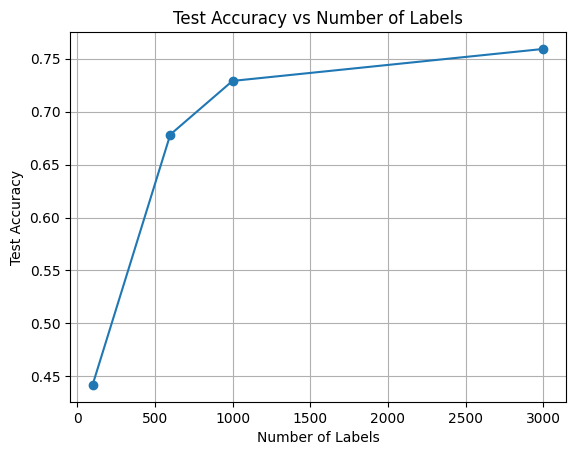

In [35]:
# Plotting our results
label_numbers = list(results.keys())
accuracies = list(results.values())

plt.figure()
plt.plot(label_numbers, accuracies, marker='o')
plt.title('Test Accuracy vs Number of Labels')
plt.xlabel('Number of Labels')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()

In [ ]:
# Loading SVM model
import joblib
num_labels_to_load = 1000  # Change this to the desired number of labels
svm = joblib.load(f'svm_model_{num_labels_to_load}.joblib')
print(f'SVM model loaded from svm_model_{num_labels_to_load}.joblib')